# ChatGPT for Text Analytics
This notebook provides a simple introduction to using ChatGPT for text analytics. It uses sentiment analysis as an example. It can be easily adapted to use other Large Language Models (e.g., Deepseek, Llama) for your particular text analytics project.

## 0. Setup for Runing in Google Colab

In [1]:
# Checking whether we are using google colab or local computer
# If we are running using local computer, we do not need to mount the google drive and
# change the workding directory
IN_COLAB=False
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")

    # mount the google drive and swith to the directory on the Google Drive that you want to run the ipynb file
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    drive_root = "/content/drive/MyDrive/Library Workshop ChatGPT for Text Analytics"    # You need to change to your working file folder if neccessary
    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

    %pwd

We're running Colab
Mounted at /content/drive

Colab: Changing directory to  /content/drive/MyDrive/Library Workshop ChatGPT for Text Analytics
/content/drive/MyDrive/Library Workshop ChatGPT for Text Analytics


## 1. Try the HKBU GenAI Platform API Service
The first step is to obtain the API access

In [ ]:
import requests

apiKey = 'YOUR_API_KEY'
basicUrl = "https://genai.hkbu.edu.hk/general/rest"
modelName = "gpt-4-o-mini"
apiVersion = "2024-10-21"

def submit(message):
    conversation = [{"role": "user", "content": message}]
    url = basicUrl + "/deployments/" + modelName + "/chat/completions/?api-version=" + apiVersion
    headers = { 'Content-Type': 'application/json', 'api-key': apiKey }
    payload = { 'messages': conversation }
    response = requests.post(url, json=payload, headers=headers)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        return 'Error:', response

result = submit("What is text analytics?")
print(result)

{'id': 'chatcmpl-BMqYFGogGhtiDqLLryx61cTdi2iAx', 'object': 'chat.completion', 'created': 1744784923, 'model': 'gpt-4o-mini-2024-07-18', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Text analytics, also known as text mining, is the process of deriving meaningful insights and information from unstructured text data using various computational and linguistic techniques. It combines natural language processing (NLP), machine learning, and statistical analysis to extract patterns, trends, and insights from large volumes of text. \n\nKey components of text analytics include:\n\n1. **Preprocessing**: This involves cleaning and preparing the text data for analysis. Techniques such as tokenization, stopword removal, stemming, and lemmatization are often used to transform raw text into a format suitable for analysis.\n\n2. **Text Representation**: Once the text is preprocessed, it needs to be represented in a numerical format that algorithms can understand. Common method

In [3]:
# Most of the time, we only need chatGPT generated text
print(result['choices'][0]["message"]["content"])

Text analytics, also known as text mining, is the process of deriving meaningful insights and information from unstructured text data using various computational and linguistic techniques. It combines natural language processing (NLP), machine learning, and statistical analysis to extract patterns, trends, and insights from large volumes of text. 

Key components of text analytics include:

1. **Preprocessing**: This involves cleaning and preparing the text data for analysis. Techniques such as tokenization, stopword removal, stemming, and lemmatization are often used to transform raw text into a format suitable for analysis.

2. **Text Representation**: Once the text is preprocessed, it needs to be represented in a numerical format that algorithms can understand. Common methods include bag-of-words, term frequency-inverse document frequency (TF-IDF), and word embeddings (like Word2Vec or GloVe).

3. **Feature Extraction**: This involves identifying and extracting significant attribute

If the code above runs successfully, we can now obtain ChatGPT responses using the API. If the code generates an error, you might need to check that your API key is correct and you have access to the specific model.

## 2. Load Our Data
- The second step is to load the data we want to analyze. Here, we load data into a Pandas DataFrame for easy processing.
- The Yelp dataset contains two columns. The first column is the text that we want to perform sentiment analysis. The second column is the correct sentiment label. We will later use these sentiment labels to evaluate the accuracy of ChatGPT for sentiment analysis. For illustration purposes, we use only a subset (i.e., 50 data rows) of the actual Yelp data.
- Unlike traditional machine learning-based text analytics methods, Large Language Models can understand raw text directly. This allows us to input raw text into LLMs without requiring much preprocessing (e.g., tokenization, normalization).

In [4]:
import pandas as pd
df = pd.read_csv("yelp_sentiment_subset.csv")
display(df.head(5))

text sentiment
0  I expected the prices of the entrees to be a l...  negative
1  Review of Buffet : \n\nUGH ! It was very very ...  negative
2  If you value your life , do n't go to Banner B...  negative
3  `` Before getting started , I 'd like to point...  positive
4  Very disappointed in this salon . Set an appt ...  negative

In [5]:
df['text'][0]

"I expected the prices of the entrees to be a little bit higher but the quality of the Chinese food was not worth the money I paid for the dishes . I got the 18 monk noodle and the traditional dimsum . If I could describe the food in one word-terrible ! Making the dimsum look pretty by topping it with gold flakes did not do anything to make up for the flavor of the dimsum . It seemed too starchy and you can hardly taste the meat . The noodles looked like a sad , greasy slop of Mai fun type noodles ( noodles were stuck together ) saturated with soy sauce for color , and garnished with a few pieces of shitake mushrooms , green onions and fine threads of carrots . And yes , portions were small , but that 's not really the worst part of the whole experience . Just poorly prepared , way overpriced Chinese food ... sorry ."

## 3. Prompt Engineering
The third step is to formulate the prompt for our task. The details of the prompts are crucial for guiding the model's behavior and influencing the output.

In [6]:
def submit_with_instruction(prompt_instruction, message):
    conversation = [
        {"role": "system", "content": prompt_instruction},
        {"role": "user", "content": message}
    ]
    url = basicUrl + "/deployments/" + modelName + "/chat/completions/?api-version=" + apiVersion
    headers = { 'Content-Type': 'application/json', 'api-key': apiKey }
    payload = { 'messages': conversation }
    response = requests.post(url, json=payload, headers=headers)

    if response.status_code == 200:
        data = response.json()
        output = data['choices'][0]["message"]["content"]  # since we only need the generated text
        return output
    else:
        return 'Error:', response


### 3.1. Zero-Shot Prompting

In [7]:
prompt_instruction = """Perform Sentiment Classification task. Given an input text, assign a sentiment label
from ['negative', 'positive']. Avoid other sentiment labels. Return the answer only contains the label.
"""
answer  = submit_with_instruction(prompt_instruction, df['text'][0])
print(answer)

negative


### 3.2. A Few-Shot Prompting
- To help chatGPT perform our task better, we can provide some demonstration examples.
- This is especially useful when your text analytics task is not a well-known task. The LLM may need some demonstration examples to learn how to perform the task effectively.

In [8]:
# To help chatGPT perform our task better, we can provide some demonstration examples
prompt_instruction = """Perform Sentiment Classification task. Given an input text, assign a sentiment label
from ['negative', 'positive']. Avoid other sentiment labels. Return the answer only contains the label. The following are some examples.

Input text: Had a great time with my beautiful wife listening to The Instant Classics .
Drinks are pricey and menu seems a little limited , but I had a great time.
Answer:positive

Input text: I have been to this location multiple times and every time the service is
horrendous and the food is mediocre . Not sure if the location being in a mall has to do
with it.
Answer:negative

"""
answer  = submit_with_instruction(prompt_instruction, df['text'][0])
print(answer)

negative


### 3.3 Our Final Prompt
Formulate the final prompt. Prompt engineering will involve multiple rounds of iterative processes.

For your task, it is better to start with the coding guideline that you designed for human coders for your task.

Here, for this sentiment analysis task, Let's say we also want to tag all the sentiment words from the text to provide an interpretable prediction.

In [9]:
# To help chatGPT to do our task better, we can provide some demonstration examples
prompt_instruction = """Perform Sentiment Classification task. Given an input text, assign a sentiment label
from ['negative', 'positive']. Avoid other sentiment labels. Additionally, identify and tag all sentiment words within the text and assign
each tagged word a sentiment score ranging from -1 to 1, where -1 indicates the most negative sentiment,
1 represents the most positive sentiment, and 0 indicates neutral sentiment.

Return the answer that contains the sentiment of the input text
and the extracted (sentiment word, sentiment score) pairs in JSON format.
The entire answer is going to consist of a single JSON object {}, and you will NOT wrap it within JSON markdown markers.

Input text: Had a great time with my beautiful wife listening to The Instant Classics .
Drinks are pricey and menu seems a little limited , but I had a great time.
Answer:
{
  "sentiment": "positive",
  "sentiment_words": [
    {
      "sentiment_word": "great",
      "sentiment_score": 0.8
    },
    {
      "sentiment_word": "beautiful",
      "sentiment_score": 0.9
    },
    {
      "sentiment_word": "pricey",
      "sentiment_score": -0.4
    },
    {
      "sentiment_word": "limited",
      "sentiment_score": -0.3
    },
    {
      "sentiment_word": "great",
      "sentiment_score": 0.8
    }
  ]
}

Input text: I have been to this location multiple times and every time the service is
horrendous and the food is mediocre . Not sure if the location being in a mall has to do
with it.
Answer:
{
  "sentiment": "negative",
  "sentiment_words": [
    {
      "sentiment_word": "horrendous",
      "sentiment_score": -0.9
    },
    {
      "sentiment_word": "mediocre",
      "sentiment_score": -0.5
    }
  ]
}

"""
answer  = submit_with_instruction(prompt_instruction, df['text'][0])
print(answer)

{
  "sentiment": "negative",
  "sentiment_words": [
    {
      "sentiment_word": "higher",
      "sentiment_score": -0.2
    },
    {
      "sentiment_word": "not worth",
      "sentiment_score": -0.8
    },
    {
      "sentiment_word": "terrible",
      "sentiment_score": -0.9
    },
    {
      "sentiment_word": "starchy",
      "sentiment_score": -0.4
    },
    {
      "sentiment_word": "hardly taste",
      "sentiment_score": -0.7
    },
    {
      "sentiment_word": "sad",
      "sentiment_score": -0.6
    },
    {
      "sentiment_word": "greasy",
      "sentiment_score": -0.5
    },
    {
      "sentiment_word": "poorly prepared",
      "sentiment_score": -0.9
    },
    {
      "sentiment_word": "overpriced",
      "sentiment_score": -0.8
    }
  ]
}


## 4. Parse the answer of ChatGPT
- We instruct the LLM to return results in a format that is easily parseable, as we will need to programmatically parse the results of LLM.
- Now, we need to parse the output so that we can use it for further analysis.

In [10]:
import json
def parse_answer(answer):
    # The ChatGPT some times surround their answer with the json md mark (e.g., ```json) even though we
    # already explicitly tell them not.
    # If the answer contains the wrapper of json (```json), we remove them
    if answer[:3] == '```':
        json_start = answer.find('{')
        json_end = answer.rfind('}')
        answer = answer[json_start:(json_end+1)]
    try: # read the json output
        output = json.loads(answer)
        label = output['sentiment']
        words = json.dumps(output['sentiment_words'])
        return (label, words)
    except:
        # If we get an error, we print the string that failed to allow debugging
        print("can not decode json: ", answer)
        return ("", "") # return empty strings for label and words

(label, words) = parse_answer(answer)
print(label)
print(words)

negative
[{"sentiment_word": "higher", "sentiment_score": -0.2}, {"sentiment_word": "not worth", "sentiment_score": -0.8}, {"sentiment_word": "terrible", "sentiment_score": -0.9}, {"sentiment_word": "starchy", "sentiment_score": -0.4}, {"sentiment_word": "hardly taste", "sentiment_score": -0.7}, {"sentiment_word": "sad", "sentiment_score": -0.6}, {"sentiment_word": "greasy", "sentiment_score": -0.5}, {"sentiment_word": "poorly prepared", "sentiment_score": -0.9}, {"sentiment_word": "overpriced", "sentiment_score": -0.8}]


## 5. Run our analysis
Now, we are ready to run chatGPT on our data. We will call LLM for each line in our data. We will get the ChatGPT answer first. Later, we will parse the chatgpt output.

In [11]:
backup_file = 'output.pkl' # We will store temporary results just in case the program crashes. This is especially useful when we use LLM API, as the LLM may sometimes refuse to provide service to you (e.g., quota issue, internet issue ...)
df['chatgpt_answer'] = "" # we store the chatgpt answer in one column of our dataframe
row_i = 0  # start to processing the data file from the first row
df.to_pickle(backup_file)

In [12]:
# If this cell crash during the runing of your analysis (e.g., chatGPT refuse connection), re-run it
import random, time

df = pd.read_pickle(backup_file)
while row_i < df.shape[0]:    # we use while loop here because if the program crashes we can re-run it
    df.loc[row_i, 'chatgpt_answer'] = submit_with_instruction(prompt_instruction, df['text'][row_i])
    time.sleep(random.randint(1,3)) # Wait for a bit. Prevent being blocked by API
    if row_i % 10 == 0:    # display progressing information
        print(f"{row_i} / {df.shape[0]} completed")

    row_i += 1
    # save the temporary results
    df.to_pickle(backup_file)
print(f"{row_i} / {df.shape[0]} completed. All done!")

0 / 49 completed
10 / 49 completed
20 / 49 completed
30 / 49 completed
40 / 49 completed
49 / 49 completed. All done!


In [13]:
display(df.head(5))

text sentiment  \
0  I expected the prices of the entrees to be a l...  negative   
1  Review of Buffet : \n\nUGH ! It was very very ...  negative   
2  If you value your life , do n't go to Banner B...  negative   
3  `` Before getting started , I 'd like to point...  positive   
4  Very disappointed in this salon . Set an appt ...  negative   

                                      chatgpt_answer  
0  {\n  "sentiment": "negative",\n  "sentiment_wo...  
1  {\n  "sentiment": "negative",\n  "sentiment_wo...  
2  {\n  "sentiment": "negative",\n  "sentiment_wo...  
3  {\n  "sentiment": "negative",\n  "sentiment_wo...  
4  {\n  "sentiment": "negative",\n  "sentiment_wo...

# 6. Post-Analysis
Following the LLM analysis, we can evaluate the peformance of the LLM on labelled data.


In [14]:
df = pd.read_pickle(backup_file)
df['llm_sentiment_prediction'] = "" # store sentiment prediction
df['tagged_words'] = "" # store tagged words
for row_i in range(0, df.shape[0]):
    (df.loc[row_i, 'llm_sentiment_prediction'],  df.loc[row_i, 'tagged_words']) = parse_answer(df.loc[row_i, 'chatgpt_answer'])

display(df)

text sentiment  \
0   I expected the prices of the entrees to be a l...  negative   
1   Review of Buffet : \n\nUGH ! It was very very ...  negative   
2   If you value your life , do n't go to Banner B...  negative   
3   `` Before getting started , I 'd like to point...  positive   
4   Very disappointed in this salon . Set an appt ...  negative   
5   I can be a bit critical of bbq , and I love th...  positive   
6   I ca n't say enough about the amazing energy a...  positive   
7   I love my dog , even though she 's a bitch . *...  positive   
8   Great subs , the Club Supreme mike 's style wa...  positive   
9   $ 5.99 breakfast steak and eggs ... \n\nTheir ...  negative   
10  I 've gone twice with this outfit . Each time ...  positive   
11  I was introduced to Einstein Bros Bagels from ...  positive   
12  `` Came in to enjoy a nice meal instead I got ...  negative   
13  I 've been going to McAuley Pediatrics for clo...  positive   
14  I 'm a huge Macy 's fan . With that being said...  negative   
15  La Tolteca is outstanding . Passing through PH...  positive   
16  We have been coming here for over 5 years and ...  negative   
17  `` DO NOT GO HERE ! Had my oil changed on 12/2...  negative   
18  This place is perfect for your average club-go...  negative   
19  Delicious ! The food is always good and fresh ...  positive   
20  So remember that movie Las Vegas vacation and ...  negative   
21  this place is on the opposite side of the of t...  negative   
22  this place used to be fun , now all you get us...  negative   
23  This buffet is hit or miss and it figures that...  negative   
24  Came by for a two night stay over the weekend ...  positive   
25  Harrah 's rooms are whatever - not to shabby ,...  positive   
26  `` The fiance was craving cheese steaks and ou...  negative   
27  BY FAR my fave lounge/drinks place.\n\nIt 's s...  positive   
28  `` This was one of the worst pedicures ever ! ...  negative   
29  Great food . The surf and turf was awesome the...  positive   
30  Great little park . I run or walk around the s...  positive   
31  Writing this review on my mobile phone while s...  negative   
32  `` Eat here , if not for the cutely portioned ...  positive   
33    Pretty good food and fun atmosphere . \n\nYo Yo  positive   
34  God love em , they have tried . The casino sti...  negative   
35                                          Wonderful  positive   
36  `` They went out of thier way to ensure that t...  negative   
37  I have been to Desert Rock Sports several time...  negative   
38  Underwhelmed , I would say the ownership\nand ...  negative   
39  omg ! wow ! ! ! that was amaze-balls ! ! ! ! B...  positive   
40  Traveling for business and dropped in for Frid...  positive   
41           Expensive and pizza was mediocre at best  negative   
42  We will not go back ! ! The ribs looked big an...  negative   
43  `` Ok yelp nation if you read my review if The...  negative   
44  I 've brought my truck here a couple of times ...  negative   
45  `` I still have the original receipt from when...  negative   
46  I traveled over to Circus Circus to meet up wi...  negative   
47  We will not be coming back here . \n\nWe were ...  negative   
48  `` Do not go here for a check up . They made m...  negative   

                                       chatgpt_answer  \
0   {\n  "sentiment": "negative",\n  "sentiment_wo...   
1   {\n  "sentiment": "negative",\n  "sentiment_wo...   
2   {\n  "sentiment": "negative",\n  "sentiment_wo...   
3   {\n  "sentiment": "negative",\n  "sentiment_wo...   
4   {\n  "sentiment": "negative",\n  "sentiment_wo...   
5   {\n  "sentiment": "positive",\n  "sentiment_wo...   
6   {\n  "sentiment": "positive",\n  "sentiment_wo...   
7   {\n  "sentiment": "positive",\n  "sentiment_wo...   
8   {\n  "sentiment": "positive",\n  "sentiment_wo...   
9   {\n  "sentiment": "negative",\n  "sentiment_wo...   
10  {\n  "sentiment": "positive",\n  "sentiment_wo...   
11  {\n  "sent

In [15]:
# evaluate the accuracy
acc = sum(df['sentiment'] == df['llm_sentiment_prediction'])/df.shape[0]
print("LLM Accuracy: ", acc)

LLM Accuracy:  0.9795918367346939


In [17]:
# We may interested in the wrong predictions. Let us show the wrong predictions
wrong_predictions = df.loc[df['sentiment'] != df['llm_sentiment_prediction']]
wrong_predictions = wrong_predictions.reset_index(drop=True)
for row_i in range(0, wrong_predictions.shape[0]):
    print(wrong_predictions['text'][row_i])
    print("True Sentiment Label: " + wrong_predictions['sentiment'][row_i])
    print("Predicted Sentiment Label: " + wrong_predictions['llm_sentiment_prediction'][row_i])
    print("Tagged words: " + wrong_predictions['tagged_words'][row_i])
    print("------------------------------------------------------------------")

`` Before getting started , I 'd like to point out that I am currently sitting in the Palms Casino , while watching my degenerate , gambleholic , asshole-of-a-friend Pete grab his ankles , as the craps table continues to sodomize his life savings . The Palms Casino may as well be a priest , and with each roll of the dice , my man Pete is looking more and more like an alter boy . An alter boy with an ugly hat . As I look at this hat , I noticed a consistent theme . This hat of his will soon be joined by his pockets , as they both prevent the world from seeing what lies beneath -- nothing . What was once there , is now missing , and it is n't pretty . Nor was it smart . With just seven strands of hair , Pete has a face incapable of pulling off the 7-Strand comb-over . So money , combined with the freedom offered in Vegas to dive head-first into a hooker , was Pete 's only hope to hump . Do n't get me wrong , P never planned on returning to Phoenix with any money , which was fine , becaus

In [18]:
# visualize the tagged sentiment words
positive_words = []
negative_words = []
for row_i in range(0, df.shape[0]):
    tagged_words = json.loads(df.loc[row_i, 'tagged_words'])
    for pair_i in tagged_words:
        if pair_i['sentiment_score'] < 0:
            negative_words.append(pair_i['sentiment_word'])
        elif pair_i['sentiment_score'] > 0:
            positive_words.append(pair_i['sentiment_word'])

In [19]:
!pip install wordcloud

Counter({'love': 5, 'good': 5, 'recommend': 5, 'great': 5, 'amazing': 3, 'friendly': 3, 'awesome': 3, 'nice': 2, 'Great': 2, 'delicious': 2, 'plus': 2, 'fun': 2, 'fantastic': 2, 'enjoy': 2, 'value': 1, 'kind': 1, 'professional': 1, 'new': 1, 'Thanks': 1, 'wait': 1, 'paying': 1, 'quality': 1, 'remember': 1, 'wonderful': 1, 'provided': 1, 'plenty': 1, 'one of a kind': 1, 'agree': 1, 'freshly': 1, 'variety': 1, 'totally': 1, 'like': 1, 'outstanding': 1, 'truth': 1, 'packed': 1, 'Five stars': 1, 'favorite': 1, 'perfect': 1, 'Delicious': 1, 'fresh': 1, 'well': 1, 'upgraded': 1, 'larger': 1, 'not too shabby': 1, 'wacky fun': 1, 'best': 1, 'fun-loving': 1, 'good time': 1, 'great mood': 1, 'fun times': 1, "grand ol' time": 1, 'smile': 1, 'fave': 1, 'intimate': 1, 'necessary': 1, 'sweetens': 1, 'regret': 1, 'mouth watering': 1, 'courtesy': 1, 'quiet': 1, 'cutely': 1, 'sexiness': 1, 'newest': 1, 'screams': 1, 'guarantee': 1, 'refreshing': 1, 'sexy': 1, 'tried': 1, 'Wonderful': 1, 'much cheaper':

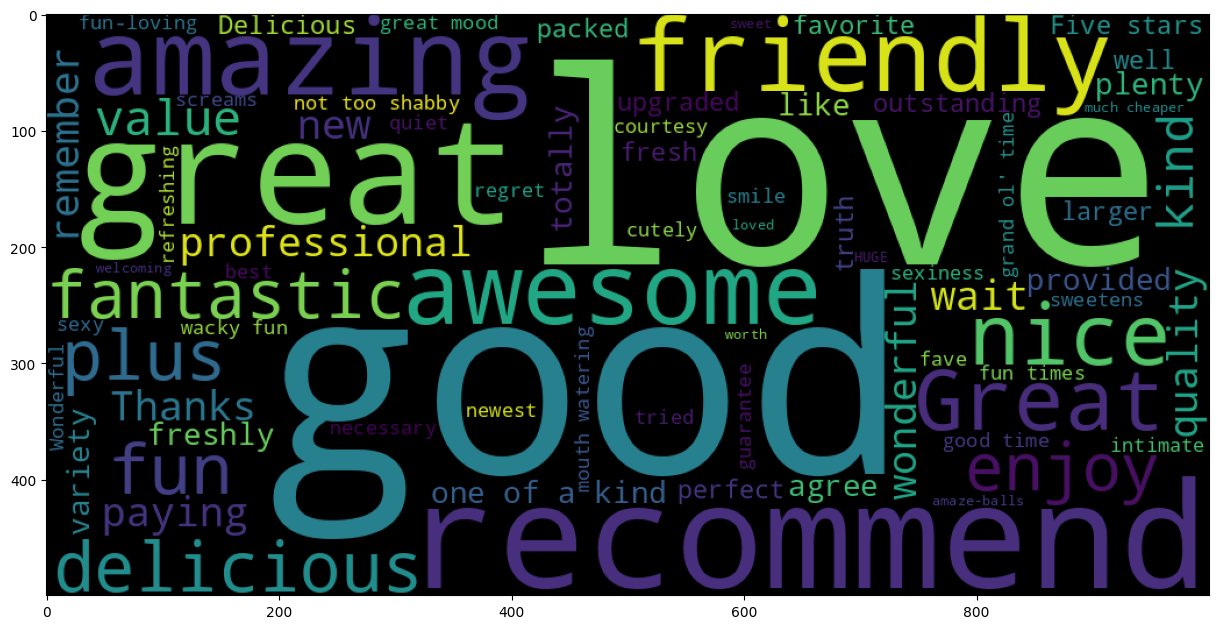

In [21]:
# Generate wordclound for positive words
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
words_count = Counter(positive_words)
print(words_count)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(words_count)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

Counter({'dry': 5, 'never': 4, 'worst': 3, 'worse': 3, 'bad': 3, 'crap': 3, 'dirty': 2, 'last time': 2, 'not': 2, 'expensive': 2, 'avoid': 2, 'strange': 2, 'wait': 2, 'cheap': 2, 'ignored': 2, 'mediocre': 2, 'terrible': 1, 'starchy': 1, 'sad': 1, 'greasy': 1, 'poorly': 1, 'overpriced': 1, 'UGH': 1, 'underwhelming': 1, 'idiot': 1, 'horrendous': 1, 'elevated': 1, 'alarmingly': 1, 'sky high': 1, 'degenerate': 1, 'asshole': 1, 'sodomize': 1, 'ugly': 1, 'not pretty': 1, 'incapable': 1, 'molested': 1, 'boredom': 1, 'drunkest': 1, 'lacking': 1, 'shit-faced': 1, 'disappointed': 1, 'rushed': 1, 'unhappy': 1, 'not great': 1, 'tasty': 1, 'charged': 1, 'complain': 1, 'sexist': 1, 'lost': 1, 'inviting': 1, 'rarely': 1, 'cold hearted': 1, 'scammed': 1, 'failed': 1, 'load of BS': 1, 'shame': 1, 'exorbitant': 1, 'shitty': 1, 'garbage': 1, 'crazy': 1, 'busy': 1, 'old': 1, 'grungy': 1, 'nervous': 1, 'creepy': 1, 'ashamed': 1, 'nothing special': 1, 'minus': 1, 'FOREVERS': 1, 'come on': 1, 'what the hell'

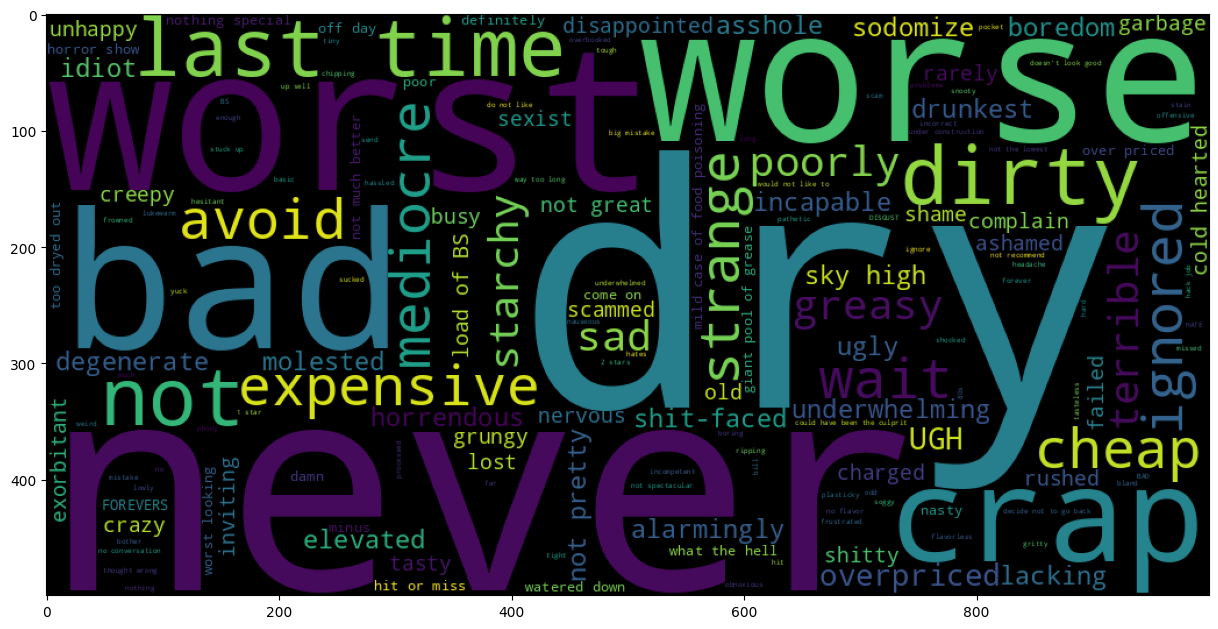

In [22]:
# Generate wordclound for negative words
words_count = Counter(negative_words)
print(words_count)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(words_count)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)